# XENON1T Position Reconstruction with Tensorflow
* Yuehuan Wei, August, 2017

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates          # for plotting dates
from matplotlib import gridspec            # to arrange the plots nicely
from scipy.optimize import curve_fit       # curve fitting libraries
import pandas as pd
from IPython.display import Image
from IPython.core.display import HTML 
from matplotlib.colors import LogNorm
from collections import defaultdict
from array import array

# Reading MC Data

In [2]:
# Read from the saved framework:
from pandas import read_hdf
df_mc = read_hdf('9e5_Train.h5', 'df_mc', format='table')
print (len(df_mc))

900000


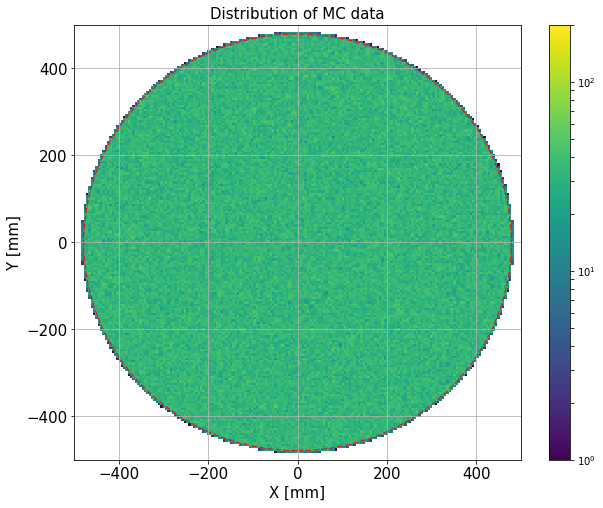

In [3]:
fig_sig= plt.figure(figsize = (10, 8))

#--------------------------------------------------------------------->
plt.hist2d(df_mc.x,  df_mc.y, range=((-520, 520), (-520, 520)), bins=(200, 200), 
           norm=matplotlib.colors.LogNorm(), vmin=1, vmax=200)
plt.colorbar()
plt.gca().add_artist(plt.Circle((0, 0), 479, color='r', fill=None, linestyle='--'))
#--------------------------------------------------------------------->

plt.xlim(-500, 500)
plt.ylim(-500, 500)

plt.xlabel('X [mm]', fontsize =15)
plt.ylabel('Y [mm]', fontsize =15)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.title('Distribution of MC data', fontsize = 15)
plt.grid(True)

plt.show()

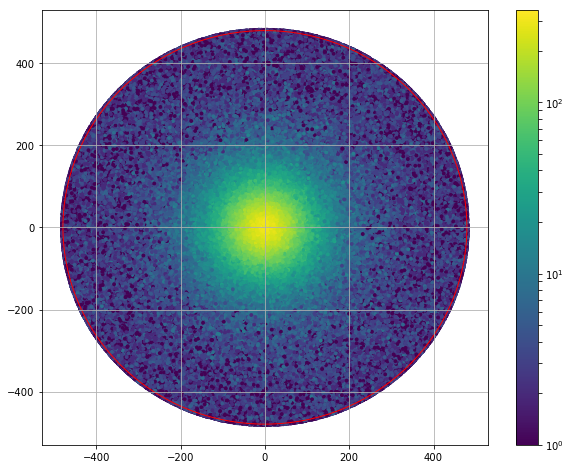

In [4]:
fig_sig= plt.figure(figsize = (10, 8))
#import seaborn as sns
#sns.set( palette="muted", color_codes=True)

plt.scatter(df_mc.x, df_mc.y, c=df_mc.S2_PMT_126, s=15, alpha=1.0, lw=0,norm=matplotlib.colors.LogNorm())
plt.colorbar()
plt.gca().add_artist(plt.Circle((0, 0), 479, color='r', fill=None))
plt.grid(True)

plt.show()

# Tensorflow (example 1: regression)

In [3]:
import tensorflow as tf
print(tf.__version__)

1.2.1


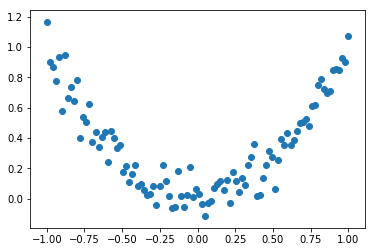

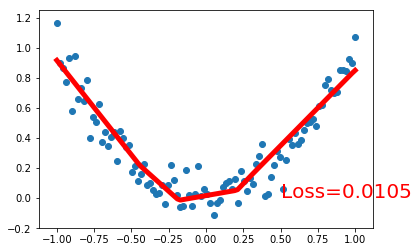

In [7]:
tf.set_random_seed(1)
np.random.seed(1)

# fake data
x = np.linspace(-1, 1, 100)[:, np.newaxis]          # shape (100, 1)
noise = np.random.normal(0, 0.1, size=x.shape)
y = np.power(x, 2) + noise                          # shape (100, 1) + some noise

# plot data
plt.scatter(x, y)
plt.show()

tf_x = tf.placeholder(tf.float32, x.shape)     # input x
tf_y = tf.placeholder(tf.float32, y.shape)     # input y

# neural network layers
l1 = tf.layers.dense(tf_x, 10, tf.nn.relu)          # hidden layer
output = tf.layers.dense(l1, 1)                     # output layer

loss = tf.losses.mean_squared_error(tf_y, output)   # compute cost
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.5)
train_op = optimizer.minimize(loss)

sess = tf.Session()                                 # control training and others
sess.run(tf.global_variables_initializer())         # initialize var in graph

plt.ion()   # something about plotting

for step in range(100):
    # train and net output
    _, l, pred = sess.run([train_op, loss, output], {tf_x: x, tf_y: y})
    if step % 5 == 0:
        # plot and show learning process
        plt.cla()
        plt.scatter(x, y)
        plt.plot(x, pred, 'r-', lw=5)
        plt.text(0.5, 0, 'Loss=%.4f' % l, fontdict={'size': 20, 'color': 'red'})
        plt.pause(0.1)

plt.ioff()
plt.show()

# Tensorflow (example 2: classification)

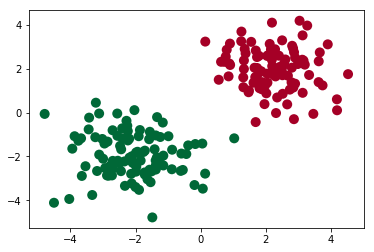

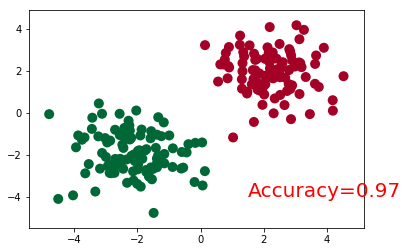

In [53]:
tf.set_random_seed(1)
np.random.seed(1)

# fake data
n_data = np.ones((100, 2))
x0 = np.random.normal(2*n_data, 1)      # class0 x shape=(100, 2)
y0 = np.zeros(100)                      # class0 y shape=(100, 1)
x1 = np.random.normal(-2*n_data, 1)     # class1 x shape=(100, 2)
y1 = np.ones(100)                       # class1 y shape=(100, 1)
x = np.vstack((x0, x1))  # shape (200, 2) + some noise
y = np.hstack((y0, y1))  # shape (200, )

# plot data
plt.scatter(x[:, 0], x[:, 1], c=y, s=100, lw=0, cmap='RdYlGn')
plt.show()

tf_x = tf.placeholder(tf.float32, x.shape)     # input x
tf_y = tf.placeholder(tf.int32, y.shape)     # input y

# neural network layers
l1 = tf.layers.dense(tf_x, 10, tf.nn.relu)          # hidden layer
output = tf.layers.dense(l1, 2)                     # output layer

loss = tf.losses.sparse_softmax_cross_entropy(labels=tf_y, logits=output)           # compute cost
accuracy = tf.metrics.accuracy(          # return (acc, update_op), and create 2 local variables
    labels=tf.squeeze(tf_y), predictions=tf.argmax(output, axis=1),)[1]
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.05)
train_op = optimizer.minimize(loss)

sess = tf.Session()                                                                 # control training and others
init_op = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())
sess.run(init_op)     # initialize var in graph

plt.ion()   # something about plotting
for step in range(100):
    # train and net output
    _, acc, pred = sess.run([train_op, accuracy, output], {tf_x: x, tf_y: y})
    if step % 2 == 0:
        # plot and show learning process
        plt.cla()
        plt.scatter(x[:, 0], x[:, 1], c=pred.argmax(1), s=100, lw=0, cmap='RdYlGn')
        plt.text(1.5, -4, 'Accuracy=%.2f' % acc, fontdict={'size': 20, 'color': 'red'})
        plt.pause(0.1)

plt.ioff()
plt.show()

# Trying with the MC data

To use the data for training, we would like to normalize first.

- x or y, divided by TPC radius. The value is 481.25 mm in MC. 
- PMT hits, divided by ntpmhits. Here, we use S2_PMT_ID/sum(S2_PMT_[0...126])

Also, don't forget to seperate the training and testing data,  we use the MSE from testing data for verifying the quaulity of net, the improving and overtraining. 

Another important issue is that, do not forget the ID of the **15 Dead PMT** on top array.

In [9]:
dead_PMT = [1,  2,  12, 26,  27, 
            34, 62, 65, 73,  79, 
            86, 88, 91, 102, 118]

print (dead_PMT)
print ('Number of the dead PMT on top array: ',len(dead_PMT))

[1, 2, 12, 26, 27, 34, 62, 65, 73, 79, 86, 88, 91, 102, 118]
Number of the dead PMT on top array:  15


Calculate S2 top total:

In [11]:
df_mc['top_total'] = df_mc[['S2_PMT_' + str(i) for i in range(127) if i not in dead_PMT]].sum(axis=1)

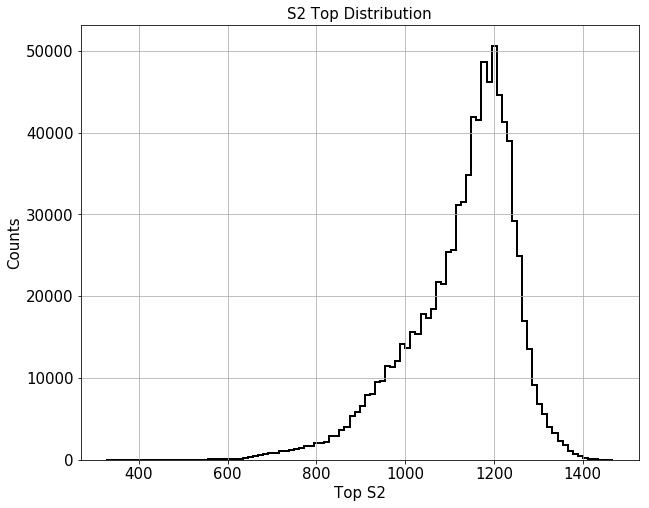

In [12]:
fig_s1 = plt.figure(figsize = (10,8))

plt.hist(df_mc.top_total, bins=100, color='black', histtype='step', linestyle='solid', linewidth=2, label='')


plt.xlabel('Top S2', fontsize =15)
plt.ylabel('Counts', fontsize =15)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.title('S2 Top Distribution', fontsize = 15)
plt.grid(True)

plt.show()

# Using MC data in Tensorflow... ...

In [6]:
hits = [df_mc['S2_PMT_'+ str(i)].values[0] for i in range(127)]

for j in range(1, 10000):
    hits_temp = [df_mc['S2_PMT_'+ str(i)].values[j] for i in range(127)]
    hits = np.vstack([hits, hits_temp])
print (hits.shape)

(10000, 127)


In [7]:
print (hits)

[[  2.   0.   0. ...,   4.   1.   2.]
 [  2.   0.   0. ...,   3.   0.   3.]
 [  2.   0.   0. ...,   5.   5.   5.]
 ..., 
 [  1.   0.   0. ...,   3.   5.   3.]
 [  0.   0.   0. ...,   4.   2.   2.]
 [  0.   0.   0. ...,  25.  13.   5.]]


In [8]:
hits_test = [df_mc['S2_PMT_'+ str(i)].values[9999] for i in range(127)]
print (hits_test)

[0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 2.0, 2.0, 1.0, 3.0, 1.0, 0.0, 0.0, 3.0, 1.0, 2.0, 0.0, 2.0, 3.0, 3.0, 3.0, 3.0, 4.0, 6.0, 6.0, 7.0, 0.0, 0.0, 5.0, 4.0, 3.0, 2.0, 1.0, 2.0, 0.0, 1.0, 2.0, 3.0, 1.0, 2.0, 3.0, 1.0, 2.0, 2.0, 2.0, 1.0, 0.0, 3.0, 2.0, 2.0, 2.0, 4.0, 4.0, 3.0, 4.0, 8.0, 7.0, 12.0, 13.0, 3.0, 4.0, 4.0, 0.0, 1.0, 4.0, 0.0, 3.0, 6.0, 2.0, 4.0, 4.0, 1.0, 1.0, 0.0, 2.0, 3.0, 0.0, 3.0, 2.0, 0.0, 10.0, 22.0, 49.0, 67.0, 26.0, 10.0, 0.0, 8.0, 0.0, 3.0, 6.0, 0.0, 3.0, 3.0, 2.0, 0.0, 3.0, 4.0, 1.0, 6.0, 8.0, 55.0, 0.0, 203.0, 35.0, 6.0, 4.0, 3.0, 5.0, 4.0, 1.0, 3.0, 4.0, 4.0, 4.0, 24.0, 123.0, 59.0, 0.0, 5.0, 4.0, 2.0, 6.0, 3.0, 25.0, 13.0, 5.0]


In [9]:
#pos = np.zeros([2])
pos = [df_mc.x.values[0], df_mc.y.values[0]]
print (pos)

for j in range(1, 10000):
    pos_temp = [df_mc.x.values[j], df_mc.y.values[j]]
    pos = np.vstack([pos, pos_temp])
print (pos.shape)
print (pos)

[213.8223876953125, 258.18063354492188]
(10000, 2)
[[ 213.8223877   258.18063354]
 [ 272.76141357 -197.39503479]
 [-351.52523804  -27.48209953]
 ..., 
 [ 158.2774353   221.78388977]
 [ 428.09741211   10.72206688]
 [-181.48579407 -131.3692627 ]]


In [10]:
pos.shape

(10000, 2)

In [11]:
hits.shape

(10000, 127)

In [12]:

tf_hits = tf.placeholder(tf.float32, shape = [None, 127])   # input PMT hits for training.
tf_pos  = tf.placeholder(tf.float32, shape = [None, 2])    # input Events positon for training.


In [13]:

# neural network layers
hiden_layer = tf.layers.dense(tf_hits, 30, tf.nn.relu)          # hidden layer
output = tf.layers.dense(hiden_layer, 2)    


In [14]:
loss = tf.losses.mean_squared_error(tf_pos, output)   # compute cost
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001)
train_op = optimizer.minimize(loss)

In [15]:
sess = tf.Session()                                 # control training and others
sess.run(tf.global_variables_initializer())         # initialize var in graph

In [22]:
for step in range(1000):
    # train and net output
    sess.run([train_op, loss, output], {tf_hits: hits, tf_pos: pos})
    if step % 10 == 0:
        print (sess.run(loss, {tf_hits: hits, tf_pos: pos}))
        


75399.6
75058.8
74724.8
74397.4
74076.4
73761.9
73453.6
73151.4
72855.2
72564.7
72280.2
72001.2
71727.8
71459.7
71197.0
70939.5
70687.1
70439.6
70197.1
69959.5
69726.5
69498.1
69274.2
69054.8
68839.8
68628.9
68422.2
68219.7
68021.1
67826.6
67635.8
67448.9
67265.6
67086.0
66910.0
66737.4
66568.2
66402.4
66239.9
66080.6
65924.5
65771.4
65621.3
65474.3
65330.1
65188.8
65050.4
64914.6
64781.6
64651.1
64523.4
64398.1
64275.2
64154.8
64036.9
63921.2
63807.8
63696.7
63587.8
63480.9
63376.2
63273.7
63173.2
63074.7
62978.1
62883.4
62790.6
62699.6
62610.5
62523.0
62437.4
62353.4
62271.1
62190.4
62111.3
62033.8
61957.8
61883.4
61810.4
61738.8
61668.6
61599.9
61532.5
61466.5
61401.7
61338.3
61276.1
61215.1
61155.3
61096.8
61039.4
60983.1
60927.9
60873.8
60820.8
60768.9
60717.9
60668.1
60619.1
60571.2
